<a href="https://colab.research.google.com/github/suryanshshah2006/Brain-Tumor-detection/blob/main/Brain_Tumor_Classification_Using_yolov8n_cls_pt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -q kaggle ultralytics
import json, os, shutil, random
from pathlib import Path

In [3]:
kaggle_username = "suryanshshah"
kaggle_token = "KGAT_c6e62e674ce15cae2dd30a93bf313757"

!mkdir -p ~/.kaggle

with open("kaggle.json", "w") as f:
    json.dump({"username": kaggle_username, "key": kaggle_token}, f)

!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("✅ Kaggle authentication successful!")

✅ Kaggle authentication successful!


In [4]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset -p /content
!unzip -q /content/brain-tumor-mri-dataset.zip -d /content/brain-tumor-mri-dataset

print("✅ Downloaded and unzipped.")
!ls -lah /content/brain-tumor-mri-dataset

Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset
License(s): CC0-1.0
 96% 143M/149M [00:00<00:00, 1.50GB/s]
100% 149M/149M [00:00<00:00, 1.44GB/s]
✅ Downloaded and unzipped.
total 16K
drwxr-xr-x 4 root root 4.0K Jan  9 14:00 .
drwxr-xr-x 1 root root 4.0K Jan  9 14:00 ..
drwxr-xr-x 6 root root 4.0K Jan  9 14:00 Testing
drwxr-xr-x 6 root root 4.0K Jan  9 14:00 Training


In [5]:
base_dir = Path("/content/brain-tumor-mri-dataset")
train_src = base_dir / "Training"
test_src  = base_dir / "Testing"

print("Training exists:", train_src.exists(), train_src)
print("Testing exists :", test_src.exists(), test_src)

print("\nTraining classes:", [p.name for p in train_src.iterdir() if p.is_dir()])
print("Testing classes :", [p.name for p in test_src.iterdir() if p.is_dir()])

Training exists: True /content/brain-tumor-mri-dataset/Training
Testing exists : True /content/brain-tumor-mri-dataset/Testing

Training classes: ['pituitary', 'glioma', 'meningioma', 'notumor']
Testing classes : ['pituitary', 'glioma', 'meningioma', 'notumor']


In [6]:
target_dir = Path("/content/yolo_dataset")
for split in ["train", "val", "test"]:
    (target_dir / split).mkdir(parents=True, exist_ok=True)

val_ratio = 0.20
seed = 123
random.seed(seed)

classes = sorted([p.name for p in train_src.iterdir() if p.is_dir()])

def copy_files(file_list, dst_folder):
    dst_folder.mkdir(parents=True, exist_ok=True)
    for f in file_list:
        shutil.copy2(f, dst_folder / f.name)

for cls in classes:
    src_cls_dir = train_src / cls
    files_cls = sorted(list(src_cls_dir.glob("*")))
    random.shuffle(files_cls)

    n_val = int(len(files_cls) * val_ratio)
    val_files = files_cls[:n_val]
    train_files = files_cls[n_val:]

    copy_files(train_files, target_dir / "train" / cls)
    copy_files(val_files,   target_dir / "val" / cls)

test_classes = sorted([p.name for p in test_src.iterdir() if p.is_dir()])
for cls in test_classes:
    files_cls = sorted(list((test_src / cls).glob("*")))
    copy_files(files_cls, target_dir / "test" / cls)

print("✅ YOLO dataset ready at:", target_dir)

✅ YOLO dataset ready at: /content/yolo_dataset


In [7]:
def count_images(split):
    counts = {}
    for cls in sorted([p.name for p in (target_dir/split).iterdir() if p.is_dir()]):
        counts[cls] = len(list((target_dir/split/cls).glob("*")))
    return counts

print("Train:", count_images("train"))
print("Val  :", count_images("val"))
print("Test :", count_images("test"))

Train: {'glioma': 1057, 'meningioma': 1072, 'notumor': 1276, 'pituitary': 1166}
Val  : {'glioma': 264, 'meningioma': 267, 'notumor': 319, 'pituitary': 291}
Test : {'glioma': 300, 'meningioma': 306, 'notumor': 405, 'pituitary': 300}


In [8]:
from ultralytics import YOLO

model = YOLO("yolov8n-cls.pt")

results = model.train(
    data=str(target_dir),
    epochs=50,
    imgsz=224,
    batch=32,
    plots=True
)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.250 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/yolo_dataset, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, k

In [9]:
print("=== Validation ===")
_ = model.val(data=str(target_dir), split="val", imgsz=224)

print("\n=== Test ===")
_ = model.val(data=str(target_dir), split="test", imgsz=224)

=== Validation ===
Ultralytics 8.3.250 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-cls summary (fused): 30 layers, 1,440,004 parameters, 0 gradients, 3.3 GFLOPs
train: /content/yolo_dataset/train... found 4571 images in 4 classes ✅ 
val: /content/yolo_dataset/val... found 1141 images in 4 classes ✅ 
test: /content/yolo_dataset/test... found 1311 images in 4 classes ✅ 
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 716.8±204.6 MB/s, size: 23.4 KB)
val: Scanning /content/yolo_dataset/val... 1141 images, 0 corrupt: 100% ━━━━━━━━━━━━ 1141/1141 2.7Mit/s 0.0s
               classes   top1_acc   top5_acc: 100% ━━━━━━━━━━━━ 72/72 16.1it/s 4.5s
                   all      0.996          1
Speed: 0.1ms preprocess, 0.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /content/runs/classify/val

=== Test ===
Ultralytics 8.3.250 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
train: /content/yolo_dataset/train... found 4571 images in

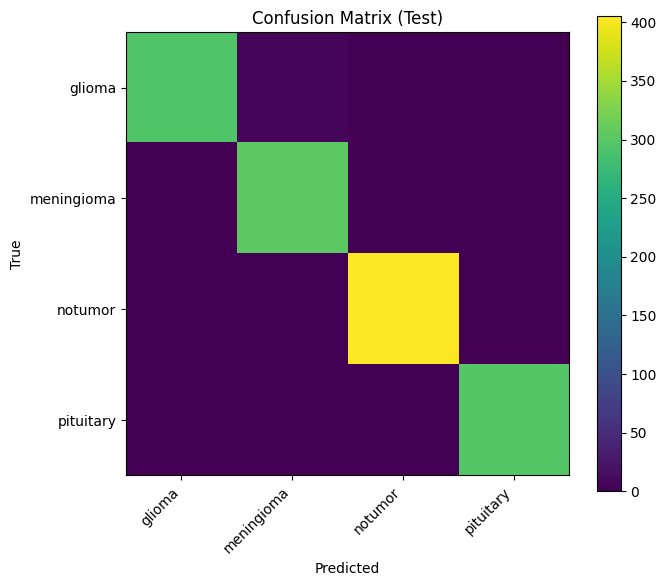


Classification Report (Test):
              precision    recall  f1-score   support

      glioma       1.00      0.98      0.99       300
  meningioma       0.98      0.99      0.99       306
     notumor       1.00      1.00      1.00       405
   pituitary       1.00      1.00      1.00       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



In [10]:
!pip -q install scikit-learn matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

test_images = []
true_labels = []

for cls in sorted([p.name for p in (target_dir/"test").iterdir() if p.is_dir()]):
    for f in (target_dir/"test"/cls).glob("*"):
        test_images.append(str(f))
        true_labels.append(cls)

pred_labels = []
for f in test_images:
    out = model.predict(source=f, imgsz=224, verbose=False)[0]
    pred_idx = int(out.probs.top1)
    pred_labels.append(out.names[pred_idx])

labels = sorted(list(set(true_labels)))
cm = confusion_matrix(true_labels, pred_labels, labels=labels)

plt.figure(figsize=(7,6))
plt.imshow(cm)
plt.title("Confusion Matrix (Test)")
plt.xticks(range(len(labels)), labels, rotation=45, ha="right")
plt.yticks(range(len(labels)), labels)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.colorbar()
plt.tight_layout()
plt.show()

print("\nClassification Report (Test):")
print(classification_report(true_labels, pred_labels, labels=labels))